# Prepare the environment: Lunar Lander

In [1]:
!pip install swig
!pip install gym[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 8.6 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 74.9 MB/s eta 0:00:00:00:0100:01
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=495258 sha256=a8b2376df9e9d370e5c5e8b2992924c3996bee538dbc3f9438c14a5763b09b51
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import gym
from IPython.display import clear_output
import torch
#from stable_baselines3 import PPO

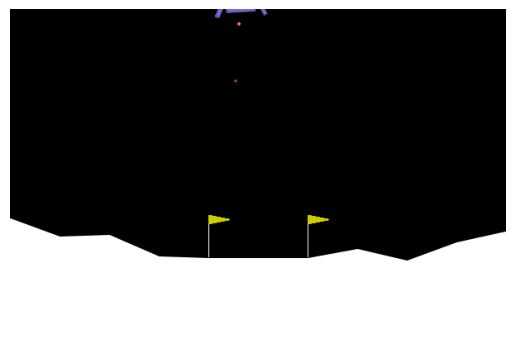

In [101]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")
observation, info = env.reset()

for _ in range(10):
    frame = env.render()
    clear_output(wait=True)
    # this is where you would insert your policy
    action = env.action_space.sample()
    plt.imshow(frame)
    plt.axis('off')  # Hide the axes
    plt.show()
    #plt.pause(0.05)
    # step (transition) through the environment with the action
    # receiving the next observation, reward and if the episode has terminated or truncated
    observation, reward, terminated, truncated, info = env.step(action)
    # If the episode has ended then we can reset to start a new episode
    if terminated or truncated:
        observation, info = env.reset()

# Agent based on RSiMBA architucture: I made a slight modification on the original archticuture SiMBA

In [9]:
!pip install einops
!pip install mamba-ssm==2.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached triton-3.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.3 kB)
Using cached triton-3.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (209.5 MB)
  Created wheel for mamba-ssm: filename=mamba_ssm-2.2.2-cp310-cp310-linux_x86_64.whl size=323998290 sha256=a658a5438dbe9fb3a53799d7d9f4714ca09225769c24ec04a403728ac7d1c69e
  Stored in directory: /root/.cache/pip/wheels/57/7c/90/9f963468ecc3791e36e388f9e7b4a4e1e3f90fbb340055aa4d
Successfully built mamba-ssm


In [10]:
from einops import rearrange, repeat, einsum
from einops.layers.torch import Rearrange
import torch.nn.functional as F
import torch.nn as nn
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class MambaBlock(nn.Module):
    def __init__(self, d_model, d_state = 64, expand = 2, d_conv = 4, conv_bias = True,  bias = False ):
        """A single Mamba block, as described in Figure 3 in Section 3.4 in the Mamba paper [1]."""
        super().__init__()
        self.d_model = d_model # Model dimension d_model
        self.d_state=d_state # SSM state expansion factor
        self.d_conv=d_conv  # Local convolution width
        self.expand=expand  # Block expansion factor
        self.conv_bias=conv_bias
        self.bias=bias
        self.d_inner = int(self.expand * self.d_model)
        self.dt_rank = math.ceil(self.d_model / 16)
        

        self.in_proj = nn.Linear(self.d_model, self.d_inner * 2, bias=self.bias)

        self.conv1d = nn.Conv1d(
            in_channels=self.d_inner,
            out_channels=self.d_inner,
            bias=self.conv_bias,
            kernel_size=self.d_conv,
            groups=self.d_inner,
            padding=self.d_conv - 1,
        )

        # x_proj takes in `x` and outputs the input-specific Δ, B, C
        self.x_proj = nn.Linear(self.d_inner, self.dt_rank + self.d_state * 2, bias=False)
        
        # dt_proj projects Δ from dt_rank to d_in
        self.dt_proj = nn.Linear(self.dt_rank, self.d_inner, bias=True)

        A = repeat(torch.arange(1, self.d_state + 1), 'n -> d n', d=self.d_inner)
        self.A_log = nn.Parameter(torch.log(A))
        self.D = nn.Parameter(torch.ones(self.d_inner))
        self.out_proj = nn.Linear(self.d_inner, self.d_model, bias=self.bias)
        

    def forward(self, x):
        """Mamba block forward. This looks the same as Figure 3 in Section 3.4 in the Mamba paper [1].
    
        Args:
            x: shape (b, l, d)    (See Glossary at top for definitions of b, l, d_in, n...)
    
        Returns:
            output: shape (b, l, d)
        
        Official Implementation:
            class Mamba, https://github.com/state-spaces/mamba/blob/main/mamba_ssm/modules/mamba_simple.py#L119
            mamba_inner_ref(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/ops/selective_scan_interface.py#L311
            
        """
        (b, l, d) = x.shape
        
        x_and_res = self.in_proj(x)  # shape (b, l, 2 * d_in)
        (x, res) = x_and_res.split(split_size=[self.d_inner, self.d_inner], dim=-1)

        x = rearrange(x, 'b l d_in -> b d_in l')
        x = self.conv1d(x)[:, :, :l]
        x = rearrange(x, 'b d_in l -> b l d_in')
        
        x = F.silu(x)

        y = self.ssm(x)
        
        y = y * F.silu(res)
        
        output = self.out_proj(y)

        return output

    
    def ssm(self, x):
        """Runs the SSM. See:
            - Algorithm 2 in Section 3.2 in the Mamba paper [1]
            - run_SSM(A, B, C, u) in The Annotated S4 [2]

        Args:
            x: shape (b, l, d_in)    (See Glossary at top for definitions of b, l, d_in, n...)
    
        Returns:
            output: shape (b, l, d_in)

        Official Implementation:
            mamba_inner_ref(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/ops/selective_scan_interface.py#L311
            
        """
        (d_in, n) = self.A_log.shape

        # Compute ∆ A B C D, the state space parameters.
        #     A, D are input independent (see Mamba paper [1] Section 3.5.2 "Interpretation of A" for why A isn't selective)
        #     ∆, B, C are input-dependent (this is a key difference between Mamba and the linear time invariant S4,
        #                                  and is why Mamba is called **selective** state spaces)
        
        A = -torch.exp(self.A_log.float())  # shape (d_in, n)
        D = self.D.float()

        x_dbl = self.x_proj(x)  # (b, l, dt_rank + 2*n)
        
        (delta, B, C) = x_dbl.split(split_size=[self.dt_rank, n, n], dim=-1)  # delta: (b, l, dt_rank). B, C: (b, l, n)
        delta = F.softplus(self.dt_proj(delta))  # (b, l, d_in)
        
        y = self.selective_scan(x, delta, A, B, C, D)  # This is similar to run_SSM(A, B, C, u) in The Annotated S4 [2]
        
        return y

    
    def selective_scan(self, u, delta, A, B, C, D):
        """Does selective scan algorithm. See:
            - Section 2 State Space Models in the Mamba paper [1]
            - Algorithm 2 in Section 3.2 in the Mamba paper [1]
            - run_SSM(A, B, C, u) in The Annotated S4 [2]

        This is the classic discrete state space formula:
            x(t + 1) = Ax(t) + Bu(t)
            y(t)     = Cx(t) + Du(t)
        except B and C (and the step size delta, which is used for discretization) are dependent on the input x(t).
    
        Args:
            u: shape (b, l, d_in)    (See Glossary at top for definitions of b, l, d_in, n...)
            delta: shape (b, l, d_in)
            A: shape (d_in, n)
            B: shape (b, l, n)
            C: shape (b, l, n)
            D: shape (d_in,)
    
        Returns:
            output: shape (b, l, d_in)
    
        Official Implementation:
            selective_scan_ref(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/ops/selective_scan_interface.py#L86
            Note: I refactored some parts out of `selective_scan_ref` out, so the functionality doesn't match exactly.
            
        """
        (b, l, d_in) = u.shape
        n = A.shape[1]
        
        # Discretize continuous parameters (A, B)
        # - A is discretized using zero-order hold (ZOH) discretization (see Section 2 Equation 4 in the Mamba paper [1])
        # - B is discretized using a simplified Euler discretization instead of ZOH. From a discussion with authors:
        #   "A is the more important term and the performance doesn't change much with the simplification on B"
        deltaA = torch.exp(einsum(delta, A, 'b l d_in, d_in n -> b l d_in n'))
        deltaB_u = einsum(delta, B, u, 'b l d_in, b l n, b l d_in -> b l d_in n')
        
        # Perform selective scan (see scan_SSM() in The Annotated S4 [2])
        # Note that the below is sequential, while the official implementation does a much faster parallel scan that
        # is additionally hardware-aware (like FlashAttention).
        x = torch.zeros((b, d_in, n), device=deltaA.device)
        ys = []    
        for i in range(l):
            x = deltaA[:, i] * x + deltaB_u[:, i]
            y = einsum(x, C[:, i, :], 'b d_in n, b n -> b d_in')
            ys.append(y)
        y = torch.stack(ys, dim=1)  # shape (b, l, d_in)
        
        y = y + u * D
    
        return y

In [14]:
import math
from mamba_ssm import Mamba
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

class PVT2FFN(nn.Module):
    def __init__(self, in_features, hidden_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.dwconv = DWConv(hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, in_features)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        x = self.fc1(x)
        x = self.dwconv(x, H, W)
        x = self.act(x)
        x = self.fc2(x)
        return x

class DWConv(nn.Module):
    def __init__(self, dim=768):
        super(DWConv, self).__init__()
        self.dwconv = nn.Conv2d(dim, dim, 3, 1, 1, bias=True, groups=dim)

    def forward(self, x, H, W):
        #print(x.shape)
        B, N, C = x.shape
        x = x.transpose(1, 2).view(B, C, H, W)
        x = self.dwconv(x)
        x = x.flatten(2).transpose(1, 2)
        return x



class RSimbaBlock(nn.Module):
    def __init__(self, embed_dim, height, width):
        super().__init__()
        self.mamba = Mamba(d_model=embed_dim, d_state=16, d_conv=8, expand=2) #optimize
        self.mlp = PVT2FFN(in_features=embed_dim, hidden_features=int(embed_dim * 2))
        self.norm = nn.LayerNorm(embed_dim)
        self.height = height
        self.width = width

    def forward(self, x):
        #print(x.shape)
        x_old = x
        x = self.mamba(x) + x + self.mlp(x,self.height,self.width)
        return self.norm(x)

/opt/conda/lib/python3.10/site-packages/mamba_ssm/ops/selective_scan_interface.py:164: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, xz, conv1d_weight, conv1d_bias, x_proj_weight, delta_proj_weight,
/opt/conda/lib/python3.10/site-packages/mamba_ssm/ops/selective_scan_interface.py:240: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, dout):
/opt/conda/lib/python3.10/site-packages/mamba_ssm/ops/triton/layer_norm.py:986: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(
/opt/conda/lib/python3.10/site-packages/mamba_ssm/ops/triton/layer_norm.py:1045: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type=

In [67]:
class ConvToMamba(nn.Module):
    def __init__(self):
        super(ConvToMamba, self).__init__()
        self.rearrange = Rearrange('b (n c) -> b n c', c = 64, n = 64)

        
    def forward(self, x):
        # Define the computation for the forward pass
        # For example, a simple linear transformation: x * weight + bias
        return self.rearrange(x)

class MambaToConv(nn.Module):
    def __init__(self):
        super(MambaToConv, self).__init__()
        self.rearrange = Rearrange('b n c -> b (n c)')

        
    def forward(self, x):
        # Define the computation for the forward pass
        # For example, a simple linear transformation: x * weight + bias
        return self.rearrange(x)

In [73]:
from torch.distributions.categorical import Categorical


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.basemodel = nn.Sequential(
            nn.Linear(8,64),
            nn.ReLU(),
            nn.Linear(64,512),
            nn.ReLU(),
            nn.Linear(512,4096),
            ConvToMamba(),
            *[RSimbaBlock(
                embed_dim = 64,
                height = 8,
                width = 8,
            ) for _ in range(4)],
            MambaToConv(),
        )
        self.actor = nn.Sequential(
            nn.Linear(4096,256),
            nn.ReLU(),
            nn.Linear(256,32),
            nn.ReLU(),
            nn.Linear(32,4)
        )
        self.critic = nn.Sequential(
            nn.Linear(4096,512),
            nn.ReLU(),
            nn.Linear(512,64),
            nn.ReLU(),
            nn.Linear(64,8),
            nn.ReLU(),
            nn.Linear(8,1),
        )

    def get_value(self, x):
        return self.critic(self.basemodel(x))

    
    def forward(self, x, action=None):
        x = self.basemodel(x)
        logits = self.actor(x)
        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), self.critic(x)



In [74]:
def make_env(env_id, seed, idx, capture_video):
    def thunk():
        env = gym.make(env_id)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        if capture_video:
            if idx == 0:
                env = gym.wrappers.RecordVideo(env, f"videos/ch")
        return env

    return thunk

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
envs = gym.vector.SyncVectorEnv(
        [make_env("LunarLander-v2", 1 + i, i, False) for i in range(4)]
    )

agent = nn.DataParallel(Model()).to(device)
#agent = Model().to(device)
optimizer = torch.optim.Adam(agent.parameters(), lr=2.5e-4, eps=1e-5)

# Training with PPO and GAE: the training done on 4 runs for this cell with different gamma and gae_lambda values

In [84]:
# ALGO Logic: Storage setup
anneal_lr = True
gae = True
norm_adv = True
clip_vloss = True
num_steps = 128
num_envs = 4
learning_rate = 2.5e-4
optimizer.param_groups[0]["lr"] = learning_rate
total_timesteps = 50000
batch_size = num_envs * num_steps
gamma = 0.999
gae_lambda = 0.95
num_minibatches = 4
update_epochs = 4
clip_coef = 0.2
ent_coef = 0.01
vf_coef = 0.5
max_grad_norm = 0.5
minibatch_size = batch_size // num_minibatches
target_kl = None



obs = torch.zeros((num_steps, num_envs) + envs.single_observation_space.shape).to(device)
actions = torch.zeros((num_steps, num_envs) + envs.single_action_space.shape).to(device)
logprobs = torch.zeros((num_steps, num_envs)).to(device)
rewards = torch.zeros((num_steps, num_envs)).to(device)
dones = torch.zeros((num_steps, num_envs)).to(device)
values = torch.zeros((num_steps, num_envs)).to(device)
# Start the game
global_step = 0
next_obs = torch.Tensor(envs.reset()[0]).to(device)
next_done = torch.zeros(4).to(device)
num_updates = total_timesteps // batch_size

for update in range(1, num_updates + 1):
    # Annealing the rate if instructed to do so.
    if anneal_lr:
        frac = 1.0 - (update - 1.0) / num_updates
        lrnow = frac * learning_rate
        optimizer.param_groups[0]["lr"] = lrnow

    for step in range(num_steps):
        global_step += 1 * num_envs
        obs[step] = next_obs
        dones[step] = next_done

        # ALGO LOGIC: action logic
        with torch.no_grad():
            action, logprob, _, value = agent(next_obs)
            values[step] = value.flatten()
        actions[step] = action
        logprobs[step] = logprob

        # TRY NOT TO MODIFY: execute the game and log data.
        next_obs, reward, terminated, truncated, info = envs.step(action.cpu().numpy())
        done  = terminated + truncated
        rewards[step] = torch.tensor(reward).to(device).view(-1)
        next_obs, next_done = torch.Tensor(next_obs).to(device), torch.Tensor(done).to(device)
        
        #print(info)
        if info and "final_info" in info.keys():
            for elem in info['final_info']:
                if elem:
                    print(f"global_step={global_step}, episodic_return= {elem['episode']['r']}, episodic_length= {elem['episode']['l']}")

    # bootstrap value if not done
    with torch.no_grad():
        next_value = agent(next_obs)[3].reshape(1, -1)
        if gae:
            advantages = torch.zeros_like(rewards).to(device)
            lastgaelam = 0
            for t in reversed(range(num_steps)):
                if t == num_steps - 1:
                    nextnonterminal = 1.0 - next_done
                    nextvalues = next_value
                else:
                    nextnonterminal = 1.0 - dones[t + 1]
                    nextvalues = values[t + 1]
                delta = rewards[t] + gamma * nextvalues * nextnonterminal - values[t]
                advantages[t] = lastgaelam = delta + gamma * gae_lambda * nextnonterminal * lastgaelam
            returns = advantages + values
        else:
            returns = torch.zeros_like(rewards).to(device)
            for t in reversed(range(num_steps)):
                if t == num_steps - 1:
                    nextnonterminal = 1.0 - next_done
                    next_return = next_value
                else:
                    nextnonterminal = 1.0 - dones[t + 1]
                    next_return = returns[t + 1]
                returns[t] = rewards[t] + gamma * nextnonterminal * next_return
            advantages = returns - values

    # flatten the batch
    b_obs = obs.reshape((-1,) + envs.single_observation_space.shape)
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape((-1,) + envs.single_action_space.shape)
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = values.reshape(-1)

    # Optimizing the policy and value network
    b_inds = np.arange(batch_size)
    clipfracs = []
    for epoch in range(update_epochs):
        np.random.shuffle(b_inds)
        for start in range(0, batch_size, minibatch_size):
            end = start + minibatch_size
            mb_inds = b_inds[start:end]

            _, newlogprob, entropy, newvalue = agent(
                b_obs[mb_inds], b_actions.long()[mb_inds]
            )
            logratio = newlogprob - b_logprobs[mb_inds]
            ratio = logratio.exp()

            with torch.no_grad():
                # calculate approx_kl http://joschu.net/blog/kl-approx.html
                old_approx_kl = (-logratio).mean()
                approx_kl = ((ratio - 1) - logratio).mean()
                clipfracs += [((ratio - 1.0).abs() > clip_coef).float().mean().item()]

            mb_advantages = b_advantages[mb_inds]
            if norm_adv:
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

            # Policy loss
            pg_loss1 = -mb_advantages * ratio
            pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - clip_coef, 1 + clip_coef)
            pg_loss = torch.max(pg_loss1, pg_loss2).mean()

            # Value loss
            newvalue = newvalue.view(-1)
            if clip_vloss:
                v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                v_clipped = b_values[mb_inds] + torch.clamp(
                    newvalue - b_values[mb_inds],
                    -clip_coef,
                    clip_coef,
                )
                v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                v_loss = 0.5 * v_loss_max.mean()
            else:
                v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

            entropy_loss = entropy.mean()
            loss = pg_loss - ent_coef * entropy_loss + v_loss * vf_coef

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
            optimizer.step()

        if target_kl is not None:
            if approx_kl > target_kl:
                break

    y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
    var_y = np.var(y_true)
    explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

global_step=1208, episodic_return= 240.30487060546875, episodic_length= 302
global_step=1732, episodic_return= 231.2761993408203, episodic_length= 433
global_step=2200, episodic_return= 209.15615844726562, episodic_length= 550
global_step=2304, episodic_return= -1.9642257690429688, episodic_length= 143
global_step=2328, episodic_return= 276.2862548828125, episodic_length= 280
global_step=2556, episodic_return= 168.24313354492188, episodic_length= 639
global_step=3764, episodic_return= 269.35491943359375, episodic_length= 302
global_step=3988, episodic_return= 195.4248809814453, episodic_length= 421
global_step=4124, episodic_return= 194.37103271484375, episodic_length= 449
global_step=4568, episodic_return= 283.5459289550781, episodic_length= 592
global_step=4932, episodic_return= 251.20330810546875, episodic_length= 236
global_step=5028, episodic_return= 296.57568359375, episodic_length= 226
global_step=5176, episodic_return= 214.96484375, episodic_length= 353
global_step=5632, episod

# Show the agent performance

In [105]:
observation, info = env.reset()

num_epsiodes = 30
average_return = 0
num_epsiode = 0
episodic_return = 0

while num_epsiode < num_epsiodes:
    action, ll, ll, lll = agent(torch.tensor(observation).reshape((1,8)).to(device) )
    observation, reward, terminated, truncated, info = env.step(action.cpu().item())
    episodic_return += reward
    
    if terminated or truncated:
        num_epsiode += 1 
        average_return += episodic_return
        print(f"Return of epsiode {num_epsiode}: {episodic_return}")
        episodic_return = 0
        observation, info = env.reset()

print(f"average return: {average_return/num_epsiodes}")

Return of epsiode 1: 261.19630332392444
Return of epsiode 2: 47.558230435464594
Return of epsiode 3: 233.65632267195508
Return of epsiode 4: 237.1796998749008
Return of epsiode 5: 208.10385876150957
Return of epsiode 6: 197.7399605221769
Return of epsiode 7: 53.28205655865645
Return of epsiode 8: 233.26461209114282
Return of epsiode 9: 246.14755220063216
Return of epsiode 10: 236.54803145172238
Return of epsiode 11: 245.20213659666052
Return of epsiode 12: 260.23762056983924
Return of epsiode 13: 275.9669130848884
Return of epsiode 14: 20.79055758749172
Return of epsiode 15: 241.2352832470545
Return of epsiode 16: 261.85924293819477
Return of epsiode 17: 225.48537238069125
Return of epsiode 18: 266.75234107507254
Return of epsiode 19: 224.0910665709447
Return of epsiode 20: 257.56875740949584
Return of epsiode 21: 252.30888159324084
Return of epsiode 22: 227.36905190253628
Return of epsiode 23: 244.19390005290666
Return of epsiode 24: 277.65619729821447
Return of epsiode 25: 285.269047

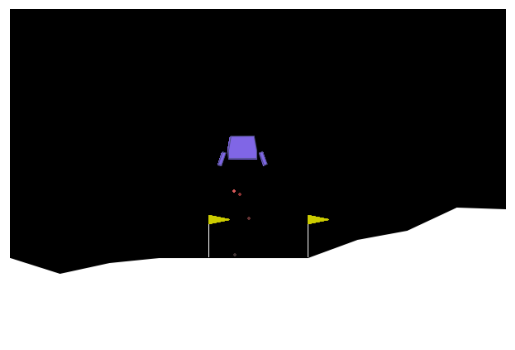

In [86]:
observation, info = env.reset()

for _ in range(400):
    frame = env.render()
    clear_output(wait=True)
    action, ll, ll, lll = agent(torch.tensor(observation).reshape((1,8)).to(device) )
    plt.imshow(frame)
    plt.axis('off')  # Hide the axes
    plt.show()
    #plt.pause(0.05)
    observation, reward, terminated, truncated, info = env.step(action.cpu().item())
    if terminated or truncated:
        observation, info = env.reset()

In [89]:
!pip install moviepy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 3.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 54.6 MB/s eta 0:00:00:00:0100:01


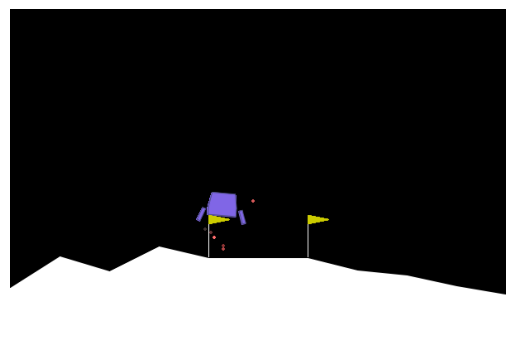

In [94]:
observation, info = env.reset()

video_folder = '/kaggle/working/recorded_videos'
env_rec = gym.wrappers.RecordVideo(env, video_folder)

for _ in range(500):
    frame = env.render()
    clear_output(wait=True)
    action, ll, ll, lll = agent(torch.tensor(observation).reshape((1,8)).to(device) )
    plt.imshow(frame)
    plt.axis('off')  # Hide the axes
    plt.show()
    #plt.pause(0.05)
    observation, reward, terminated, truncated, info = env_rec.step(action.cpu().item())
    if terminated or truncated:
        observation, info = env.reset()

# Save agent

In [95]:
# Save the agent state_dict
torch.save(agent.state_dict(), 'agent_lunar_lander.pth')
torch.save(agent, 'agent_full.pth')